Importing Libraries and Dataset from FRED

In [41]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import datetime
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [42]:
#Defining the start and end date for the data
start = datetime(2000,1, 1)
end = datetime(2024, 12, 31)

In [43]:
# Fetch Unemployment Rate Data from FRED
unemployment = web.DataReader("KENNGDPRPCPCPPPT", "fred", start, end)
unemployment = pd.DataFrame(unemployment)
unemployment.reset_index(inplace=True)
unemployment.columns = ['Date', 'Unemployment Rate']
unemployment['Date'] = pd.to_datetime(unemployment['Date'])
unemployment.set_index('Date', inplace=True)
unemployment.head()

,Unemployment Rate
Date,
2000-01-01,-2.374320
2001-01-01,1.233561
2002-01-01,-2.103288
2003-01-01,0.053514
2004-01-01,1.772686


**Data Preprocessing**

In [44]:
# Checking for missing values
unemployment.isnull().sum()

,0
Unemployment Rate,0


In [45]:
unemployment.index = pd.to_datetime(unemployment.index)
unemployment.index

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [46]:
# Ensuring the data is sorted by date
unemployment.sort_index(inplace=True)
unemployment.head()

,Unemployment Rate
Date,
2000-01-01,-2.374320
2001-01-01,1.233561
2002-01-01,-2.103288
2003-01-01,0.053514
2004-01-01,1.772686


**Exploratory Data Analysis**

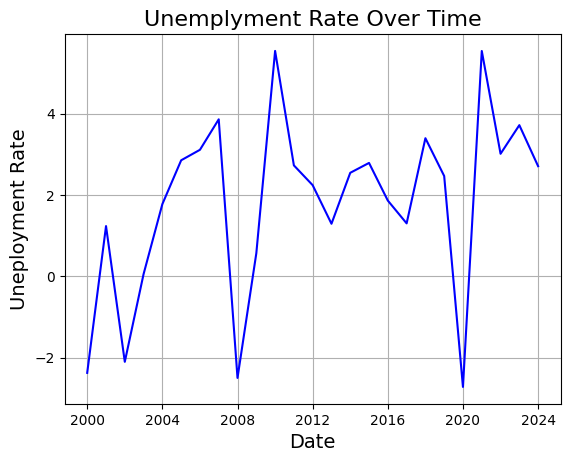

In [47]:
#Plotting the Unemployment Rate Time Series
plt.Figure(figsize=(12, 6))
plt.plot(unemployment.index, unemployment['Unemployment Rate'], color='blue')
plt.title('Unemplyment Rate Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Uneployment Rate', fontsize=14)
plt.grid()

**Stationarity Check**

In [48]:
#Checking for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', '#Observations Used']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis: The time series is stationary")
    else:
        print("Fail to reject the null hypothesis: The time series is non-stationary")
    # Call the adf_test function on the 'Unemployment Rate' column

# Call the adf_test function on the 'Unemployment Rate' column
adf_test(unemployment['Unemployment Rate'])

ADF Test Statistic : -3.5807065345439986
p-value : 0.006140772364886859
#Lags Used : 1
#Observations Used : 23
Reject the null hypothesis: The time series is stationary


**Checking for Seasonality, Trend and Noise**

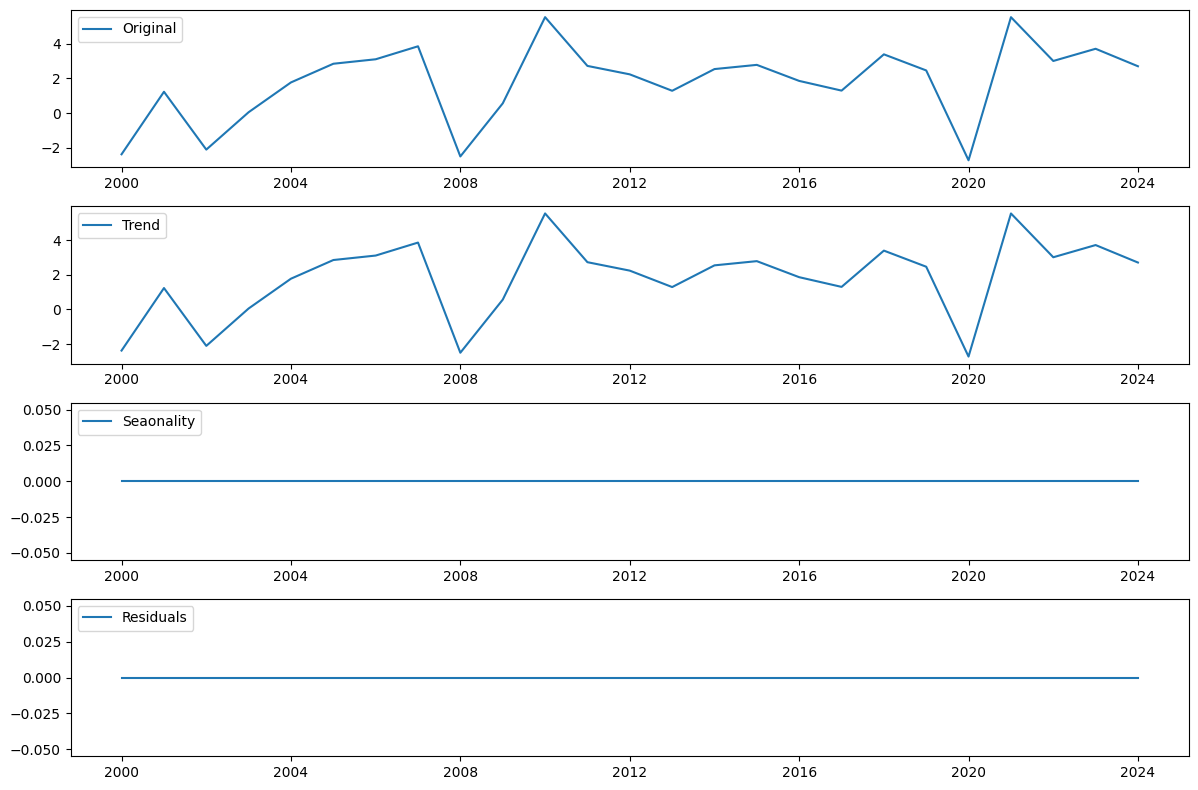

In [49]:
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(unemployment['Unemployment Rate'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.4)
plt.subplot(411)
plt.plot(unemployment['Unemployment Rate'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seaonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Preparation**

<Figure size 1200x600 with 0 Axes>

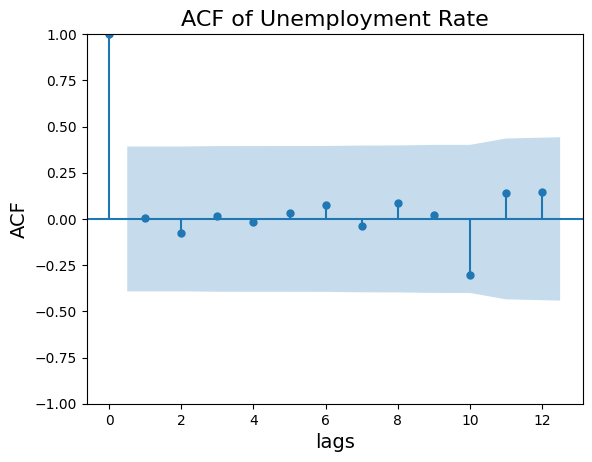

<Figure size 1200x600 with 0 Axes>

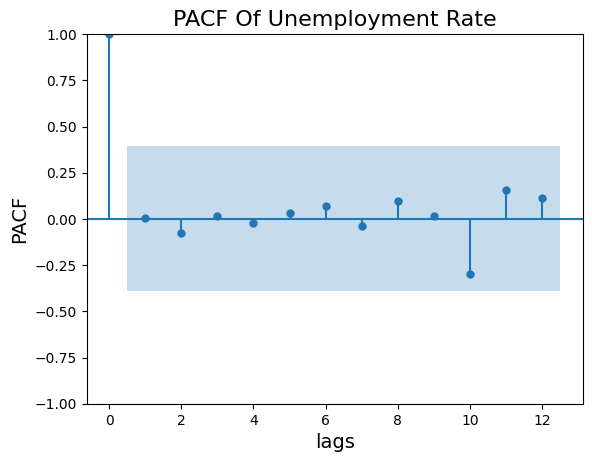

In [50]:
# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_acf(unemployment['Unemployment Rate'], lags=12)
plt.title('ACF of Unemployment Rate', fontsize= 16)
plt.xlabel('lags', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_pacf(unemployment['Unemployment Rate'], lags=12)
plt.title('PACF Of Unemployment Rate', fontsize= 16)
plt.xlabel('lags', fontsize=14)
plt.ylabel('PACF', fontsize=14)
plt.show()

**Modelling**

1. ARIMA Model

Mean Squared Error (MSE): 7.702471101166033
Mean Absolute Error (MAE): 2.164513196484479
Mean Absolute Percentage Error (MAPE): 0.6416025370163124


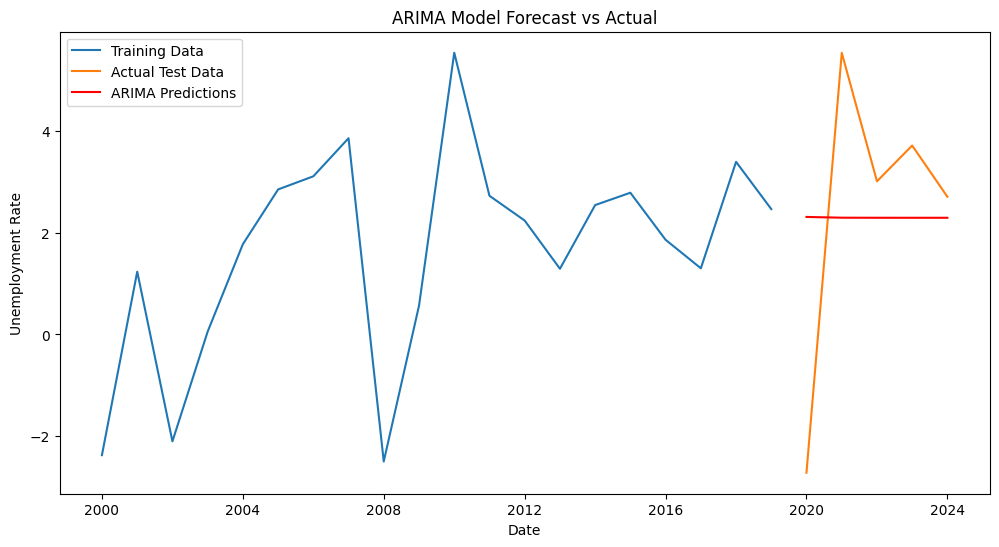

In [51]:
# Split the data into training and testing sets
train_size = int(len(unemployment) * 0.8)  # 80% for training
train_data, test_data = unemployment['Unemployment Rate'][0:train_size], unemployment['Unemployment Rate'][train_size:]

# Define the ARIMA model order (p, d, q) - these are example values, you might need to adjust them
# Based on the ACF and PACF plots
p, d, q = 1, 1, 1

# Create and fit the ARIMA model
model = SARIMAX(train_data, order=(p, d, q))
arima_model = model.fit()

# Make predictions
predictions = arima_model.predict(start=len(train_data), end=len(unemployment)-1)

# Evaluate the model
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(predictions.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()

Future Predictions

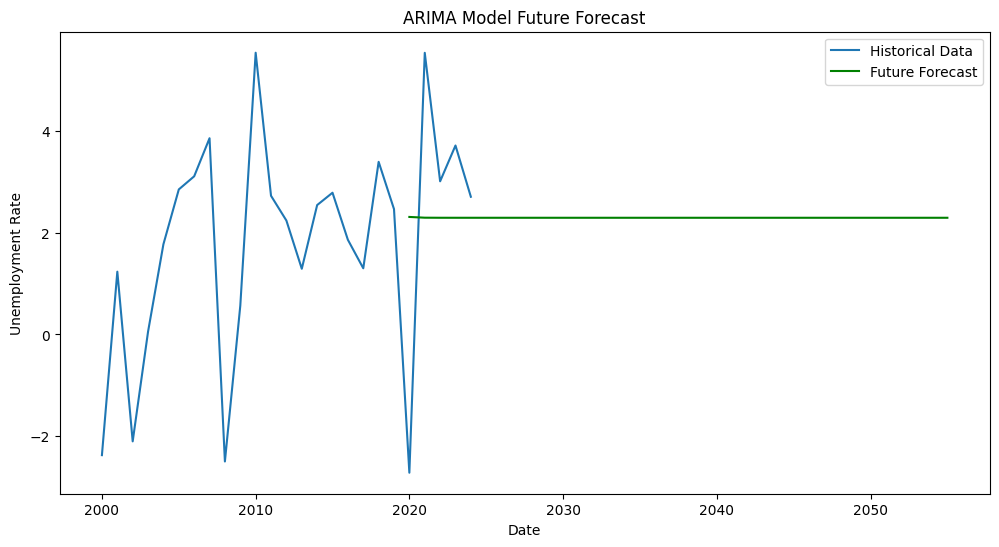

In [52]:
# Forecast future values (example: forecasting the next 36 periods)
future_forecast = arima_model.forecast(steps=36)

# Plot the future forecast
plt.figure(figsize=(12, 6))
plt.plot(unemployment.index, unemployment['Unemployment Rate'], label='Historical Data')
plt.plot(future_forecast.index, future_forecast, label='Future Forecast', color='green')
plt.title('ARIMA Model Future Forecast')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()